## Correlation: &thinsp; clouds (high and low) and ROME

LCF - Low Cloud Fraction <br>
HCF - High Cloud Fraction <br>
<br>

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
from os.path import expanduser
home = expanduser("~")


import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from plotFuncs_corr import *
import skimage.measure as skm
from scipy import stats

In [2]:
variables_x = [
    'rome',
    'rome_n',
    'o_number'
    ]

variables_y = [
    'clouds',
    'cloud_low',
    'cloud_high'
    ]

In [3]:
model = 'GFDL-CM3'
var2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_y[0] +'_tMean_historical.nc')
var2

<xarray.Dataset>
Dimensions:              (lat: 22, lon: 128)
Coordinates:
  * lat                  (lat) float64 -29.3 -26.51 -23.72 ... 23.72 26.51 29.3
  * lon                  (lon) float64 0.0 2.812 5.625 ... 351.6 354.4 357.2
    time                 object ...
Data variables:
    cloud_low_tMean      (lat, lon) float64 ...
    cloud_low_snapshot   (lat, lon) float64 ...
    cloud_high_tMean     (lat, lon) float64 ...
    cloud_high_snapshot  (lat, lon) float64 ...

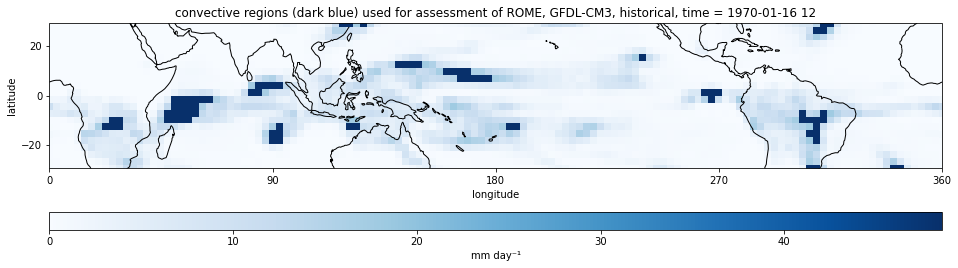

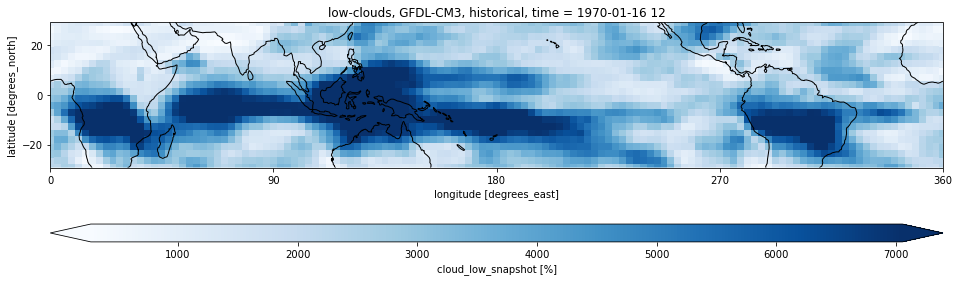

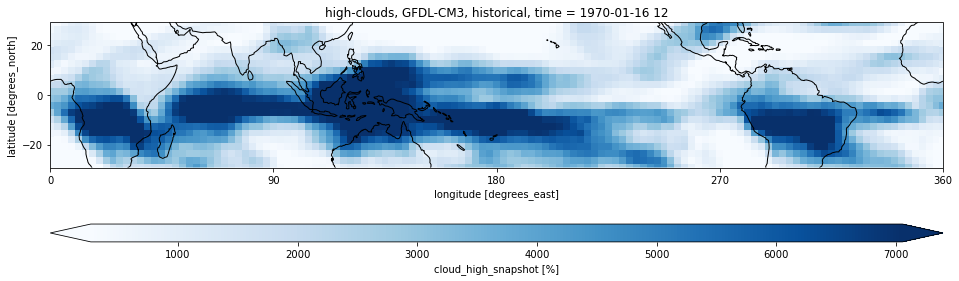

In [4]:
model = 'GFDL-CM3'
experiment = 'historical'

scene_background = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_precip_tMean_historical.nc')['precip_snapshot']
threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_prPercentiles_' + experiment + '.nc').pr97.mean(dim='time').values
L = skm.label(scene_background.where(scene_background>=threshold,0)>0, background=np.nan,connectivity=2)
L = (L>0)*1
labelMatrix = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': scene_background.lat.data, 'lon': scene_background.lon.data}
    )
scene1 = labelMatrix.where(labelMatrix>0)
scene2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_y[0] +'_tMean_historical.nc')['cloud_low_snapshot']
scene3 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_y[0] +'_tMean_historical.nc')['cloud_high_snapshot']

cmap_background= 'Blues'
cmap = 'Blues_r'
title = 'convective regions (dark blue) used for assessment of ROME, ' + model + ', ' + experiment + ', time = ' + str(scene2.coords['time'].values)[:13] 
plot_sceneThreshold(scene_background, scene1, cmap_background, cmap, title,fig_width=16 ,fig_height=8)

ds = [scene2, scene3]
vmin, vmax = [], []
for dataset in ds:
    vmin = np.append(vmin, dataset.quantile(0.10,dim=('lat','lon')))
    vmax = np.append(vmax, dataset.quantile(0.90,dim=('lat','lon')))
vmin = np.min(vmin)
vmax = np.max(vmax)

cmap="Blues"
title = 'low-clouds, ' + model + ', historical, ' + 'time = ' + str(scene2.coords['time'].values)[:13] 
plot_scene(scene2, cmap, title, vmin, vmax,fig_width=17.5 ,fig_height=8)

cmap="Blues"
title = 'high-clouds, ' + model + ', historical, ' + 'time = ' + str(scene3.coords['time'].values)[:13] 
plot_scene(scene3, cmap, title, vmin, vmax,fig_width=17.5 ,fig_height=8)


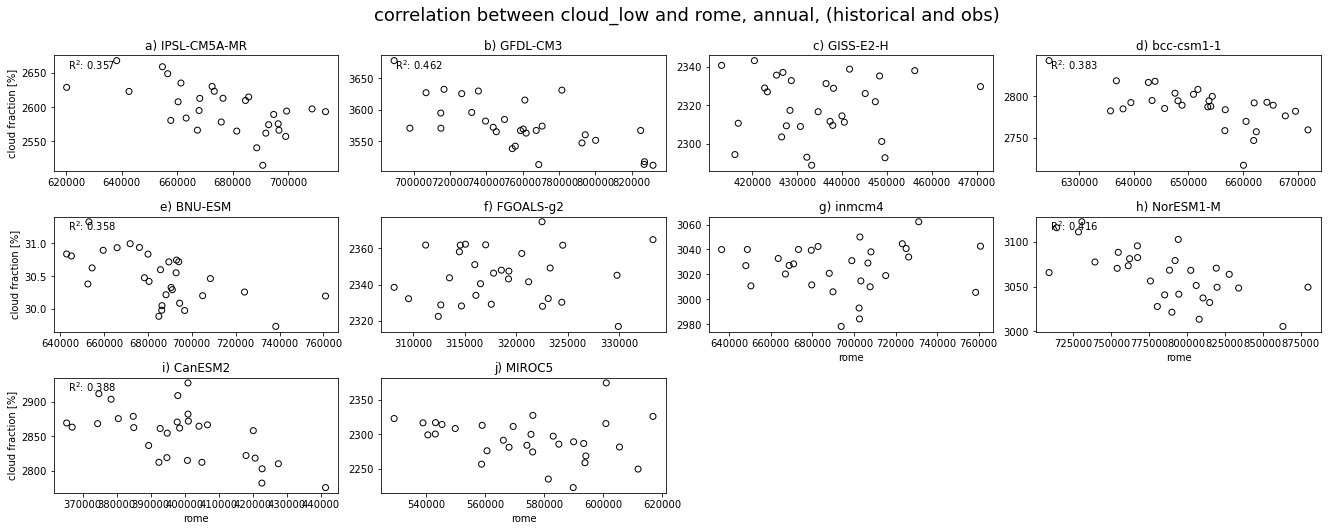

In [8]:
varTypes = [
    # 'wap500'
    # 'area_ascent'
    # 'area_descent'
]

timeMean_options = [
    'annual',
    # 'season',
    # 'season_mean',
    # 'month',
    # 'month_mean',
    # 'day',
    ]
timeMean_option = timeMean_options[0]


models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    'GISS-E2-H',    # 3 # does not have wap
    'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # does not have wap
    # 'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    'inmcm4',       # 13 # does not have wap
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]




experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]

observations = [
    # 'GPCP'
]


ds_x = xr.Dataset()
ds_y = xr.Dataset()
for model in models:
    x = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_x[0] +'_' + experiment + '.nc')[variables_x[0]]
    x_resampled = resample(x, timeMean_option)
    x_resampled.attrs['units']= x.units
    ds_x[model] = x_resampled

    y = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_y[0] +'_sMean_' + experiment + '.nc')[variables_y[1]+'_sMean']
    y_resampled = resample(y, timeMean_option)

    if varTypes == 'area_ascent':
        y_resampled = ((y_resampled<0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    if varTypes == 'area_descent':
        y_resampled = ((y_resampled>0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    
    y_resampled.attrs['units']= y.units
    ds_y[model] = y_resampled


for obs in observations:
    x = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_'+ variables1[0] +'_.nc')[variables1[0]]
    x_resampled = resample(x, timeMean_option)
    x_resampled.attrs['units']= x.units
    ds_x[model] = x_resampled

    y = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_'+ variables2[0] +'_sMean_.nc')['wap500_sMean']
    y_resampled = resample(y, timeMean_option)
    if varTypes == 'area_ascent':
        y_resampled = ((y_resampled<0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    if varTypes == 'area_descent':
        y_resampled = ((y_resampled>0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    y_resampled.attrs['units']= y.units
    ds_y[obs] = y_resampled


ymin, ymax = [], []
for dataset in list(ds_y.data_vars.keys()):
    ymin = np.append(ymin, ds_y[dataset].min())
    ymax = np.append(ymax, ds_y[dataset].max())

ymin = np.min(ymin)
ymax = np.max(ymax)

xmin, xmax = [], []
for dataset in list(ds_x.data_vars.keys()):
    xmin = np.append(xmin, ds_x[dataset].min())
    xmax = np.append(xmax, ds_x[dataset].max())
xmin = np.min(xmin)
xmax = np.max(xmax)



title = 'correlation between ' + variables_y[1] + ' and ' + variables_x[0] + ', ' + timeMean_option + ', (' + experiment + ' and obs)'
ylabel= 'cloud fraction'
xlabel = 'rome'
plot_scatter_multiple(ds_x, ds_y, timeMean_option, title, ylabel, xlabel)

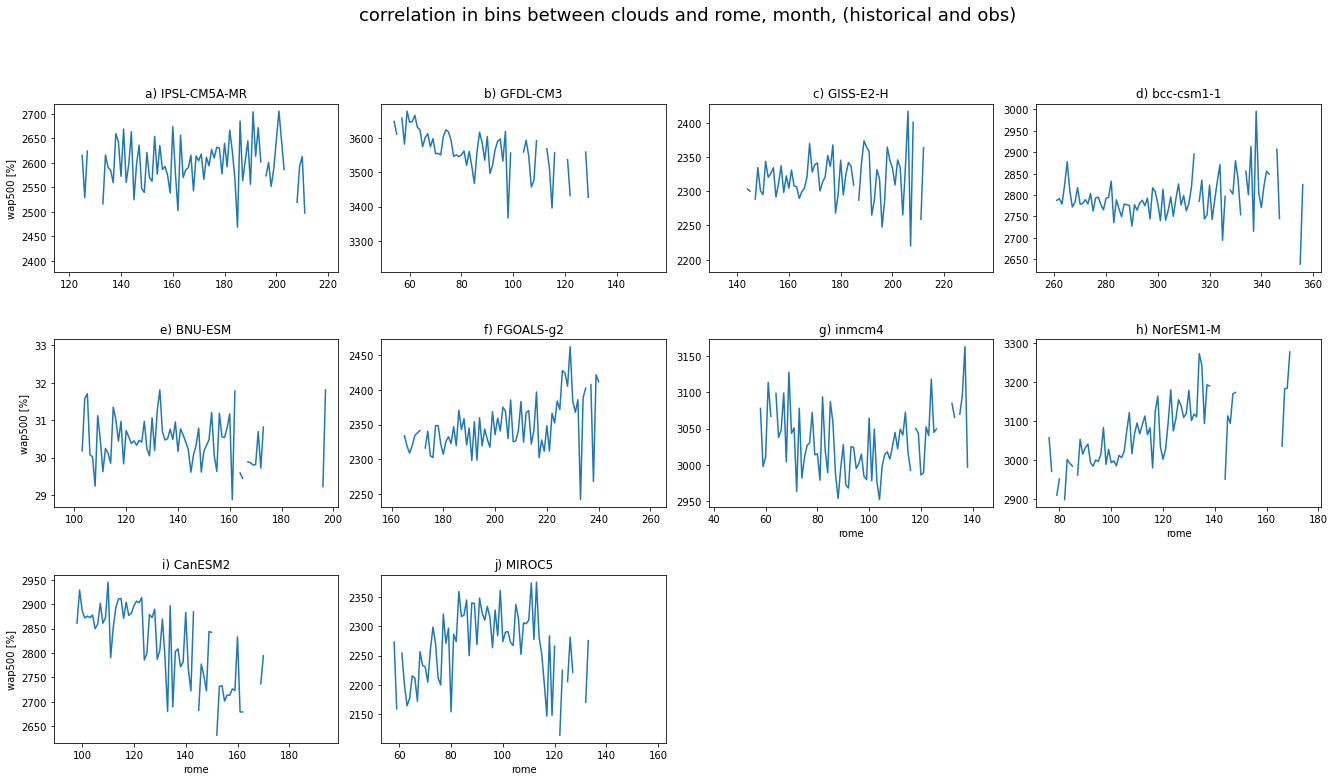

In [6]:
title = 'correlation in bins between ' + variables_y[0] + ' and ' + variables_x[0] + ', ' + timeMean_option + ', (' + experiment + ' and obs)'
ylabel= 'wap500'
xlabel = 'rome'
plot_bins_multiple(ds_x, ds_y, timeMean_option, title, ylabel, xlabel)

In [7]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments=[
    'historical', 
    # 'rcp85'
    ]
experiment = experiments[0]


org_options = [
    'rome',
    # 'rome_n',
    # 'o_number'
    ]
org_option = org_options[0]


cloud_options = [
    'cloud_low'
    # 'cloud_high'
    ]
cloud_option = cloud_options[0]

if org_option == 'rome' or org_option == 'rome_n':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]

if org_option == 'o_number':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_numberIndex_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]


folder = home + '/Documents/data/cmip5/ds'
fileName = model + '_cl_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
clouds = ds[cloud_option]
clouds.attrs['units']='%'

aWeights = np.cos(np.deg2rad(clouds.lat))

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/cbla0002/Documents/data/cmip5/ds/GFDL-CM3_cl_historical.nc'

### examples of hig and low cloud scene

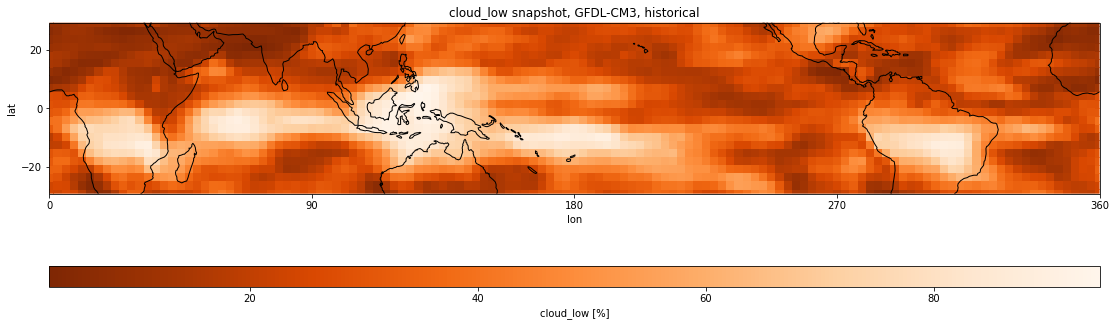

In [ ]:
var = clouds.isel(time=0)
variable_name = cloud_option
cmap = 'Oranges_r'

plot_snapshot(var, variable_name, cmap)

### individual time series

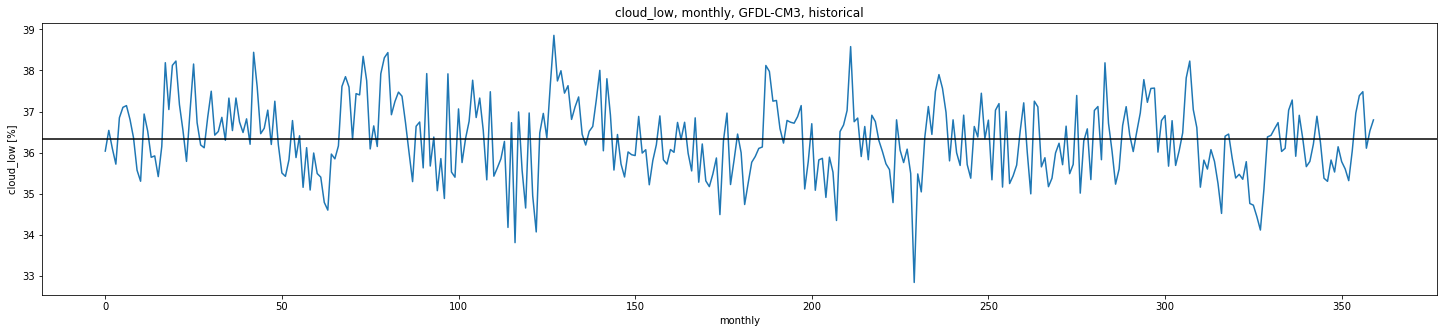

In [ ]:
y = clouds.weighted(aWeights).mean(dim=('lat','lon'), keep_attrs=True)
variable_name = cloud_option
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

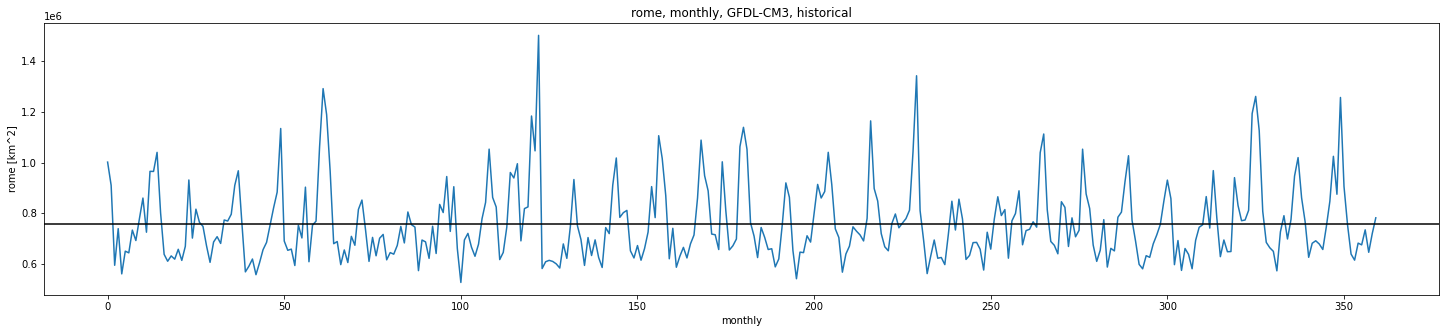

In [ ]:
y = org.resample(time='M').mean(dim='time', keep_attrs=True)
variable_name = org_option
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

## Correlations

### monthly

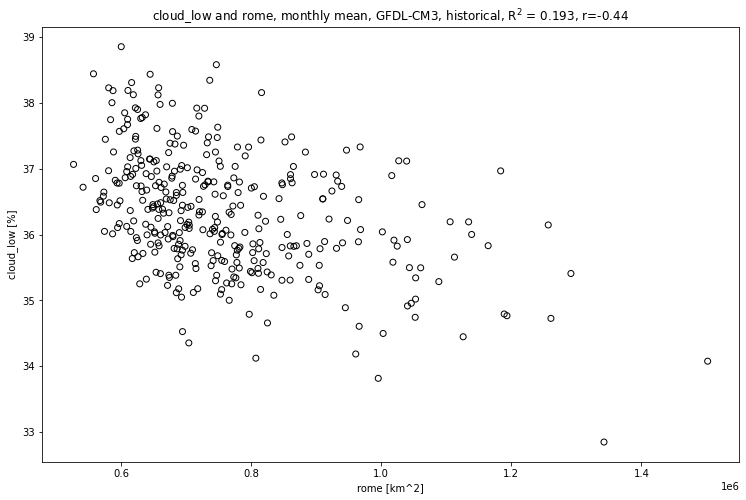

In [ ]:
x = org.resample(time='M').mean(dim='time', keep_attrs=True)
y = clouds.weighted(aWeights).mean(dim=('lat','lon'), keep_attrs=True)
scatter_type = 'monthly mean'

plot_scatter(x,y,scatter_type)